In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from math import ceil

In [ ]:
with open("../../scores_withmeta.pickle", "rb") as f:
    scheme_scores_4_adaptive = pickle.load(f)

#sort which has alpha
for key in scheme_scores_4_adaptive:
    timeouts = 0
    for i in range(len(scheme_scores_4_adaptive[key])):
        if "timeout" in scheme_scores_4_adaptive[key][i] and scheme_scores_4_adaptive[key][i]["timeout"] == True:
            timeouts += 1
    print(key, timeouts)
    has_alpha = np.zeros((len(scheme_scores_4_adaptive[key])), dtype=bool)
    for i in range(len(scheme_scores_4_adaptive[key])):
        if "alpha" in scheme_scores_4_adaptive[key][i]:
            has_alpha[i] = True
    scheme_scores_4_adaptive[key] = [scheme_scores_4_adaptive[key][i] for i in range(len(has_alpha)) if has_alpha[i]]

corotating_xy_virt_z 44
commensurate_x_virt_z 0


In [3]:
def do2(force_res=None):
    if len(plot_axes) == 2:
        print("Doing 2D plot")
        score_maps = {}
        for key in scheme_scores_4_adaptive:
            datapoints = scheme_scores_4_adaptive[key]
            #check if plot axes are present
            timeouts = 0
            for i,dp in enumerate(datapoints):
                if "timeout" in dp.keys() and dp["timeout"]:
                    timeouts += 1
            print(f"Timeouts for scheme {key}: {timeouts}")
            mask = np.zeros(len(datapoints), dtype=bool)
            for i,dp in enumerate(datapoints):
                mask[i] = True
                for pa in plot_axes:
                    if not pa in dp.keys():
                        mask[i] = False
            datapoints = [dp for i,dp in enumerate(datapoints) if mask[i]]
            print(f"Threw out {np.sum(~mask)-timeouts} datapoints due to missing data")
            print(f"Length of set: {len(datapoints)}")
            
            distance_2_isoaxis = np.zeros(len(datapoints))
            for i,dp in enumerate(datapoints):
                for ia in iso_axes:
                    distance_2_isoaxis[i] += (dp[ia] - iso_axes[ia])**2
            distance_2_isoaxis = np.sqrt(distance_2_isoaxis)
            plot_axis_x = np.full(len(datapoints), np.nan)
            plot_axis_y = np.full(len(datapoints), np.nan)
            for i,dp in enumerate(datapoints):
                plot_axis_x[i] = dp[plot_axes[0]]
                plot_axis_y[i] = dp[plot_axes[1]]
            scores = np.zeros(len(datapoints))
            for i,dp in enumerate(datapoints):
                scores[i] = dp["score"]
            nanmask = np.isnan(plot_axis_x) | np.isnan(scores)
            plot_axis_x = plot_axis_x[~nanmask]
            plot_axis_y = plot_axis_y[~nanmask]
            scores = scores[~nanmask]
            distance_2_isoaxis = distance_2_isoaxis[~nanmask]
            lset = len(scores)
            #do a k=2 nearest neighbour plot
            from sklearn.neighbors import NearestNeighbors
            from tqdm import tqdm
            nbrs = NearestNeighbors(n_neighbors=5, algorithm='brute').fit(np.array([plot_axis_x, plot_axis_y]).T)
            res = ceil(np.sqrt(lset))
            res = 3 * res
            if force_res is not None: res = force_res
            X = np.linspace(np.min(plot_axis_x), np.max(plot_axis_x), res)
            Y = np.linspace(np.min(plot_axis_y), np.max(plot_axis_y), res)
            X, Y = np.meshgrid(X, Y)
            Z = np.zeros(X.shape)
            for i in tqdm(range(X.shape[0])):
                for j in range(X.shape[1]):
                    distances, indices = nbrs.kneighbors(np.array([[X[i,j], Y[i,j]]]))
                    Z[i,j] = scores[indices[0][1]]
                #the above but vectorized
                #distances, indices = nbrs.kneighbors(np.array([[X[i,j], Y[i,j]] for j in range(X.shape[1])]))
                #Z[i,:] = scores[indices[0][1:]]
            #as a first simple thing: plot this
            plt.imshow(Z, extent=(np.min(plot_axis_x), np.max(plot_axis_x), np.min(plot_axis_y), np.max(plot_axis_y)), origin="lower", aspect="auto")
            plt.colorbar(label="Fidelity")#, boundaries = (0.7,1.0))
            plt.clim(0.85, 1.0)
            plt.title(f'Scheme "{key}" fidelities')
            plt.xlabel(fr"${plot_axes[0]}$ [ns]")
            #make a secondary y-axis with the extra_axis
            #points = np.linspace(np.min(plot_axis_y), np.max(plot_axis_y), 10)
            #!todo
            #try:
            #    plt.ylabel(fr"$\{plot_axes[1]}$ [GHz]")
            #except:
            plt.ylabel(fr"${plot_axes[1]}$ [GHz]")
            #plt.scatter(plot_axis_x, plot_axis_y, c=distance_2_isoaxis, cmap="hot", norm=LogNorm(np.min(distance_2_isoaxis), np.max(distance_2_isoaxis)), s=10, alpha=0.7)
            plt.scatter(plot_axis_x, plot_axis_y, s=10, alpha=0.7, c="black")
            #plt.colorbar(label="Distance to isoaxis")
            plt.show()
            score_maps[key] = Z
        return score_maps

In [4]:
def do1():
    if len(plot_axes) == 1:
        print("Doing 1D plot")
        for key in scheme_scores_4_adaptive:#key is just the gate that is attempted
            datapoints = scheme_scores_4_adaptive[key]
            print(f"Length of set: {len(datapoints)}")
            timeouts = 0
            for i,dp in enumerate(datapoints):
                if "timeout" in dp.keys() and dp["timeout"]:
                    timeouts += 1
            print(f"Of which, {timeouts} where thrown out due to timeouts")
            other_errors = 0
            for i,dp in enumerate(datapoints):
                if dp["score"] == None:# or not (np.isinstance(dp["score"], float) or np.isinstance(dp["score"], np.float64)):
                    other_errors += 1
            print(f"Of which, {other_errors-timeouts} where thrown out due to other errors")
            distance_2_isoaxis = np.zeros(len(datapoints))
            for i,dp in enumerate(datapoints):
                for ia in iso_axes:
                    distance_2_isoaxis[i] += (dp[ia] - iso_axes[ia])**2
            distance_2_isoaxis = np.sqrt(distance_2_isoaxis)
            plot_axis = np.full(len(datapoints), np.nan)
            for i,dp in enumerate(datapoints):
                plot_axis[i] = dp[plot_axes[0]]
            scores = np.zeros(len(datapoints))
            for i,dp in enumerate(datapoints):
                scores[i] = dp["score"]
            nanmask = np.isnan(plot_axis) & np.isnan(scores) & (scores==None)
            plot_axis = plot_axis[~nanmask]
            scores = scores[~nanmask]
            distance_2_isoaxis = distance_2_isoaxis[~nanmask]
            distance_cut_mask = distance_2_isoaxis < 1*np.max(distance_2_isoaxis)
            lset = len(plot_axis)
            enable_color = True
            plot_axis = plot_axis[distance_cut_mask]
            scores = scores[distance_cut_mask]
            distance_2_isoaxis = distance_2_isoaxis[distance_cut_mask]
            #make a cmap after the distance to the plot axis
            if True:#enable_color:
                cmap = plt.cm.hot
                #norm = LogNorm(np.min(distance_2_isoaxis), np.max(distance_2_isoaxis))
                plt.scatter(plot_axis, scores, c=distance_2_isoaxis, cmap=cmap, s=10, alpha=0.7)
                #plt.scatter(plot_axis, scores)
                plt.colorbar(label="Distance to isoaxis")
            else:
                plt.scatter(plot_axis, scores, s=10, alpha=0.7)
            plt.title(f'Scheme "{key}" scores')
            plt.xlabel(fr"${plot_axes[0]}$ ns")
            plt.ylabel("Fidelity")
            #plt.xscale("log")
            plt.show()


Doing 1D plot
Length of set: 386
Of which, 0 where thrown out due to timeouts
Of which, 0 where thrown out due to other errors


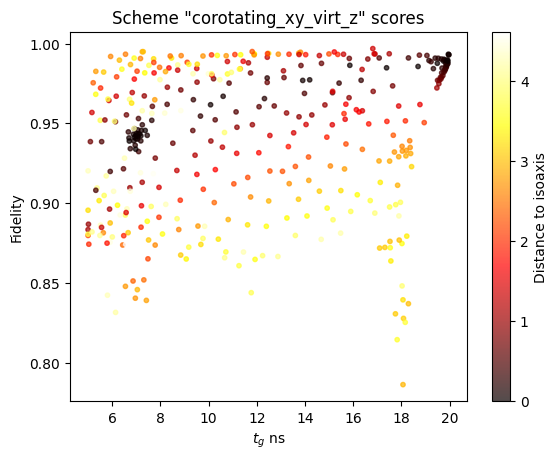

Length of set: 464
Of which, 0 where thrown out due to timeouts
Of which, 0 where thrown out due to other errors


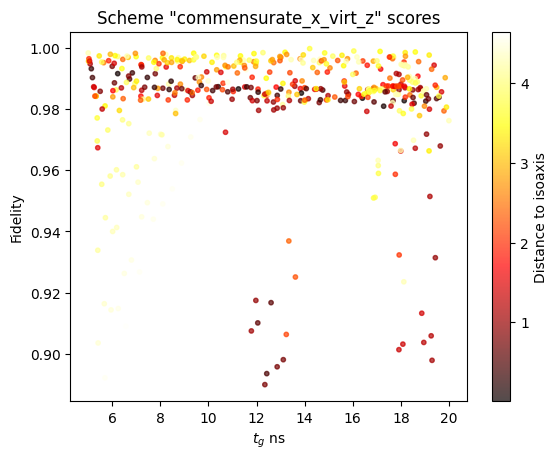

In [5]:
plot_axes = [
    "t_g"
]
iso_axes = {
    "Ec": 1.3,
    "El": 0.59,
    "Ej": 5.71,
    "L1": 1.58e-4,
    "L2": 1.58e-4,
}
do1()

In [6]:
plot_axes = [
    "t_g",
    "alpha"
]
iso_axes = {
    "Ec": 1.3,
    "El": 0.59,
    "L1": 1.58e-4,
    "L2": 1.58e-4,
}
#do2()

Doing 2D plot
Timeouts for scheme corotating_xy_virt_z: 0
Threw out 0 datapoints due to missing data
Length of set: 386


100%|██████████| 60/60 [00:08<00:00,  7.13it/s]


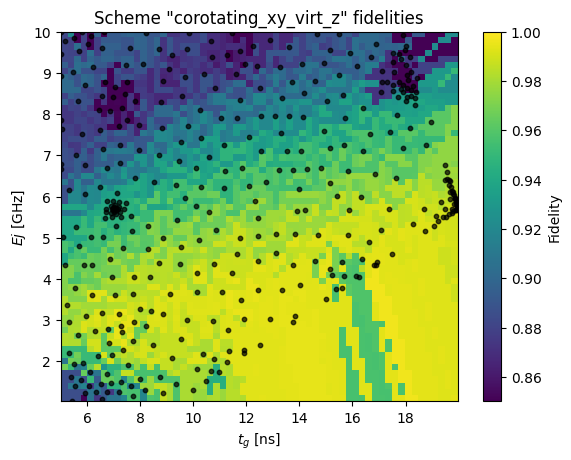

Timeouts for scheme commensurate_x_virt_z: 0
Threw out 0 datapoints due to missing data
Length of set: 464


100%|██████████| 66/66 [00:09<00:00,  6.79it/s]


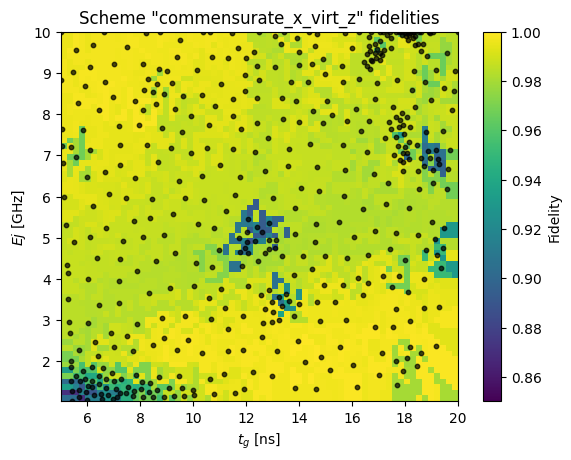

Doing 2D plot
Timeouts for scheme corotating_xy_virt_z: 0
Threw out 0 datapoints due to missing data
Length of set: 386


100%|██████████| 180/180 [01:09<00:00,  2.60it/s]


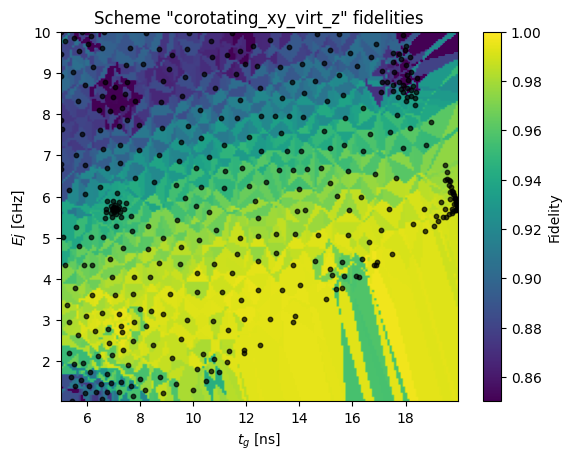

Timeouts for scheme commensurate_x_virt_z: 0
Threw out 0 datapoints due to missing data
Length of set: 464


100%|██████████| 180/180 [01:11<00:00,  2.53it/s]


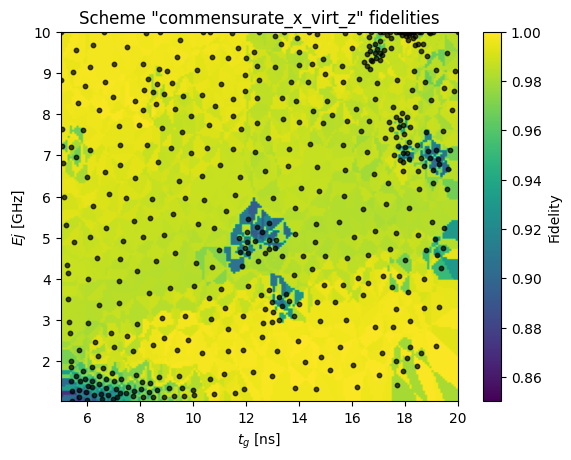

In [7]:
plot_axes = [
    "t_g",
    "Ej"
]
extra_axis = [
    None,
    "alpha"
]
iso_axes = {
    "Ec": 1.3,
    "El": 0.59,
    "L1": 1.58e-4,
    "L2": 1.58e-4,
}
do2()
score_maps = do2(force_res=60*3)

/tmp/ipykernel_1230023/567056556.py:57: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([0],[0],c=maps[0](0.5), s=100, label=f"Scheme = {list(scheme_scores_4_adaptive.keys())[0]}")
/tmp/ipykernel_1230023/567056556.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([0],[0],c=maps[1](0.5), s=100, label=f"Scheme = {list(scheme_scores_4_adaptive.keys())[1]}")


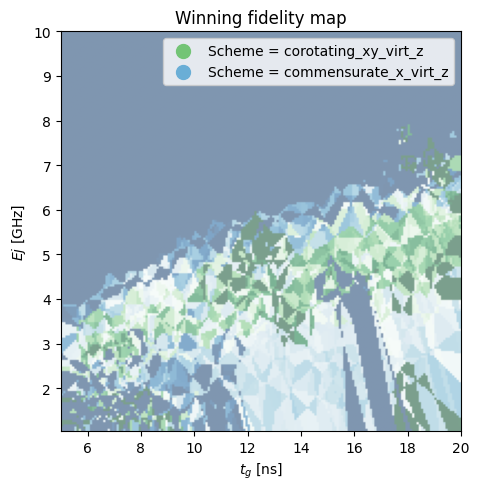

In [8]:
key0 = list(score_maps.keys())[0]
cof_len = len(score_maps[key0])
cof_array = []
for i in range(len(score_maps[key0])):
    cof_array.append([])
    for j in range(len(score_maps[key0])):
        cof_array[i].append([])
        for k,key in enumerate(score_maps):
            cof_array[i][j].append(score_maps[key][i,j])
            #normalize 
        #cof_array[i][j] /= np.sum(cof_array[i][j])
        cof_array[i][j] -= np.min(cof_array[i][j])
        #cof_array[i][j] /= np.max(cof_array[i][j])
        cof_array[i][j] *= 80
cof_array = np.array(cof_array)

#not put the two datasets in the same picture with their own colormaps
cs = ["Greens", "Blues", "Reds"]
#green_map  = plt.get_cmap("Greens")
#red_map    = plt.get_cmap("Reds")
#blue_map   = plt.get_cmap("Blues")
maps = [plt.get_cmap(cs[i]) for i in range(len(cs))]
def cof2color(cof,maps):
    color_rgbs = []
    for i in range(len(cof)):
        rgb = maps[i](cof[i])
        color_rgbs.append(rgb)
    color_rgbs = np.array(color_rgbs)
    color_rgbs = np.mean(color_rgbs, axis=0)
    color_rgbs = np.array([color_rgbs[i] for i in range(len(color_rgbs)) if i != 3])
    return color_rgbs

#plot
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax.set_title("Winning fidelity map")
ax.set_xlabel(fr"${plot_axes[0]}$ [ns]")
ax.set_ylabel(fr"${plot_axes[1]}$ [GHz]")
Z_rgbs = np.zeros((cof_len, cof_len, 3))
for i in range(cof_len):
    for j in range(cof_len):
        Z_rgbs[i,j] = cof2color(cof_array[i,j], maps)
Z_rgbs = Z_rgbs.reshape((cof_len, cof_len, 3))
all_points = []
for key in scheme_scores_4_adaptive:
    dps = scheme_scores_4_adaptive[key]
    for dp in dps:
        axvar1 = dp[plot_axes[0]]
        axvar2 = dp[plot_axes[1]]
        all_points.append((axvar1,axvar2))
all_points = np.array(all_points).T
X = np.linspace(np.min(all_points[0]), np.max(all_points[0]), cof_len)
Y = np.linspace(np.min(all_points[1]), np.max(all_points[0]), cof_len)
X, Y = np.meshgrid(X, Y)
ax.imshow(Z_rgbs, extent=(np.min(all_points[0]), np.max(all_points[0]), np.min(all_points[1]), np.max(all_points[1])), origin="lower", aspect="auto")
ax.scatter([0],[0],c=maps[0](0.5), s=100, label=f"Scheme = {list(scheme_scores_4_adaptive.keys())[0]}")
ax.scatter([0],[0],c=maps[1](0.5), s=100, label=f"Scheme = {list(scheme_scores_4_adaptive.keys())[1]}")
plt.xlim(np.min(all_points[0]), np.max(all_points[0]))
plt.ylim(np.min(all_points[1]), np.max(all_points[1]))
plt.legend()
plt.show()